In [3]:
from torch.autograd import Variable, Function
import torch

# 生成Variable
x = Variable(torch.ones(2, 2), requires_grad=True) # requires_grad表示在backward是否计算其梯度
print(x)

print('-----------------------')

# 查看Variable的属性.data, .grad, .creator
print(x.data)    # Variable保存的值
print(x.grad)    # 由于目前还未进行.backward()运算，因此不存在梯度
print(x.grad_fn) # 对于手动声明的Variable，不存在grad_fn/creator，即在计算图中，该Variable不存在父节点

print('-----------------------')

# Variable进行运算
y = x + 2
print(y)
print(y.grad_fn) # y存在x这个父节点，并且通过'+'这个Function进行连接，因此y.grad_fn是运算+:Add
print(y.grad)#由于目前还未进行.backward()运算，因此不存在梯度

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
-----------------------
tensor([[1., 1.],
        [1., 1.]])
None
None
-----------------------
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
None


In [3]:
# 生成计算图
x = Variable(torch.ones([1]), requires_grad=True)
y = 0.5 * (x + 1).pow(2)
z = torch.log(y)

# 进行backward
# 注意这里等价于z.backward(torch.Tensor([1.0]))，参数表示的是后面的输出对Variable z的梯度,即z对参数求导
#torch.Tensor([1.0])即torch.Tensor([1.])即x，z.backward()即z.backward(x)
z.backward() #z.backward(x)
#因为backward()只求图中叶子的梯度（即无父节点）!所以x有梯度，而y没有求梯度。
#以a为底的X的对数 的导数是1/xlna ，以e为底的是1/x 
print(x.grad)
# 此时y.grad为None，如果需要对y求梯度，则可以使用`register_hook`
print(y.grad)

print(y.grad_fn)#Mul,只显示最后一个计算操作。
print(z.grad_fn)#log

tensor([1.])
None


In [35]:
from graphviz import Digraph
import re
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Variable
import torchvision.models as models

def make_dot(var):
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d' % v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                print('car')
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                print('f')
                u = var.variable
                name = ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                print('d')
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                print('b')
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                print('s')
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)

    return dot 

tensor([1.], requires_grad=True)
tensor([2.], grad_fn=<MulBackward0>)
<class 'LogBackward'>
d
b
d
b
d
b
d
b
f
b


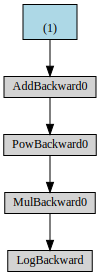

In [37]:

# yum install xdg-utils
# 生成一个计算图y = 0.5*(x + 1)^2;  z = ln(y)
x = Variable(torch.ones([1]), requires_grad=True)
y = 0.5 * (x + 1).pow(2)
z = torch.log(y)
print(x)
print(y)
print(type(z.grad_fn))
# 产生可视化计算图
g = make_dot(z)
g